In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import optimize
from numpy.linalg import eigvals
from numba import njit

In [7]:
#Define function S
# @njit
# def S(x):
#     return np.tanh(x)
@njit
def S(x):
    """
    S function
    """
    return np.tanh(x/2)/2

#Define S prime
# @njit
# def S_prime(x):
#     return 1 - np.tanh(x)**2
@njit
def S_prime(x):
    return 1/4*(1-np.tanh(x/2)**2)

#Define the System of equations
@njit
def wilson_covan (y, wEE, wEI, wIE, wII, P, t):
    E, I = y
    P_E, P_I = P
    tau_E, tau_I = t
    dEdt = (-E + S (wEE * E - wEI * I + P_E)) / tau_E
    dIdt = (-I + S (wIE * E - wII * I + P_I)) / tau_I
    return np.array([dEdt, dIdt])

#Define the Jacobian matrix 
@njit
def jacobian(y, wEE, wEI, wIE, wII, P, t):
    E, I = y
    P_E, P_I = P
    tau_E, tau_I = t

    dEdE = (-1 + wEE * S_prime(wEE * E - wEI * I + P_E))/tau_E
    dEdI = -wEI * S_prime(wEE * E - wEI * I +P_E) / tau_E
    dIdE = wIE * S_prime(wIE * E - wII * I + P_I) / tau_I
    dIdI = (-1 - wII*S_prime(wIE * E - wII * I + P_I))/ tau_I

    return np.array([dEdE, dEdI, dIdE, dIdI])


In [8]:
# Grid setup
wEE_vals = np.linspace(0.1, 30, 300)
wIE_vals = np.linspace(0.1, 20, 300)
wEI, wII = 10, 1  # Fixed inhibitory parameters
WEE, WIE = np.meshgrid(wEE_vals, wIE_vals)

# Containers
num_fixed_points = np.zeros_like(WEE, dtype=int)
has_SN = np.zeros_like(WEE, dtype=bool)
has_Hopf = np.zeros_like(WEE, dtype=bool)
has_TB = np.zeros_like(WEE, dtype=bool)

# Multiple initial guesses to find multiple fixed points
N = 100
x = 2
initial_guesses = np.zeros((N, 2))

for i in range(N):
    initial_guesses[i] = np.array([np.random.uniform(-x, x), np.random.uniform(-x, x)])

# Tolerances
tol_fp = 1e-3
tol_bif = 5e-2

for i in tqdm(range(WEE.shape[0])):
    for j in range(WEE.shape[1]):
        wEE = WEE[i, j]
        wIE = WIE[i, j]
        fixed_points = [[0, 0]]

        for guess in initial_guesses:
            sol = optimize.root(wilson_covan, guess, args=(wEE, wIE, wEI, wII, (0, 0), (1, 1)))
            if sol.success:
                if not any(np.allclose(sol.x, fp, atol=tol_fp) for fp in fixed_points):
                    fixed_points.append(sol.x)

                    J = jacobian(sol.x, wEE, wEI, wIE, wII, P=[0, 0], t=[1, 1])
                    J = np.array([[J[0], J[1]], [J[2], J[3]]])
                    tr = np.trace(J)
                    det = np.linalg.det(J)

                    if abs(tr) < tol_bif and abs(det) < tol_bif:
                        has_TB[i, j] = True
                    elif abs(det) < tol_bif:
                        has_SN[i, j] = True
                    elif abs(tr) < tol_bif and det > 0:
                        has_Hopf[i, j] = True

        num_fixed_points[i, j] = len(fixed_points)


100%|██████████| 300/300 [08:07<00:00,  1.63s/it]


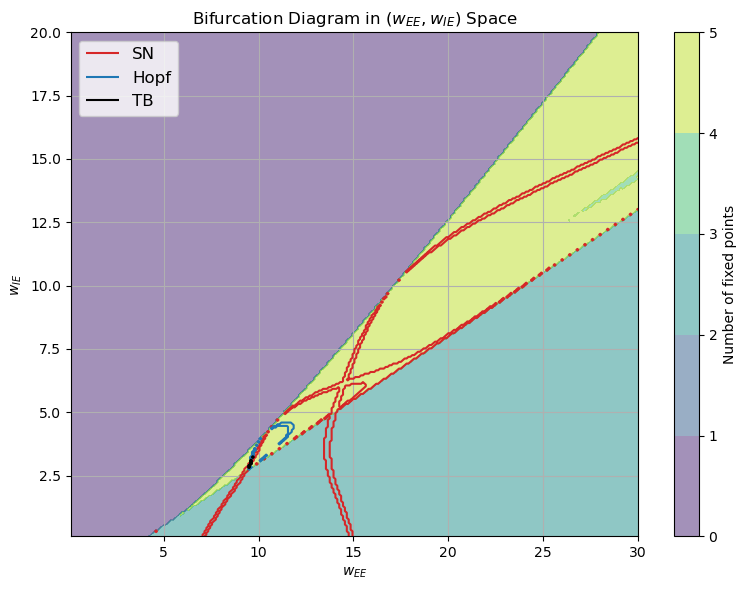

In [30]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

c = ax.contourf(WEE, WIE, num_fixed_points, levels=[0, 1, 2, 3, 4, 5], cmap="viridis", alpha=0.5)
plt.colorbar(c, ax=ax, label='Number of fixed points')

cs_SN = ax.contour(WEE, WIE, has_SN, levels=[0.5], colors='tab:red', linewidths=1.5, linestyles='solid')
cs_Hopf = ax.contour(WEE, WIE, has_Hopf, levels=[0.5], colors='tab:blue', linewidths=1.5, linestyles='solid')
cs_TB = ax.contour(WEE, WIE, has_TB, levels=[0.5], colors='black', linewidths=1.5, linestyles='solid')

h_SN, l_SN = cs_SN.legend_elements()
h_Hopf, l_Hopf = cs_Hopf.legend_elements()
h_TB, l_TB = cs_TB.legend_elements()

ax.legend(h_SN + h_Hopf + h_TB,["SN", "Hopf", "TB"] , loc='upper left', fontsize=12)

ax.set_xlabel('$w_{EE}$')
ax.set_ylabel('$w_{IE}$')
ax.set_title('Bifurcation Diagram in $(w_{EE}, w_{IE})$ Space')
plt.grid(True)
plt.tight_layout()
plt.show()